# VGGNet

## Import Library

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

from utils import train_loop,test_loop

## Check MPS Device for GPU

In [2]:
import torch
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
else:
    print('can use GPU')
    
mps_device = torch.device("mps")

can use GPU


## Load Data

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

training_data = datasets.Caltech256(
    root = '../data/',
    download=True,
    transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ])
)

test_data = datasets.Caltech256(
    root='../data/',
    download=True,
    transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ])
)

train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=256, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
training_data

Dataset Caltech256
    Number of datapoints: 30607
    Root location: ../data/caltech256
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               Grayscale(num_output_channels=1)
               ToTensor()
           )

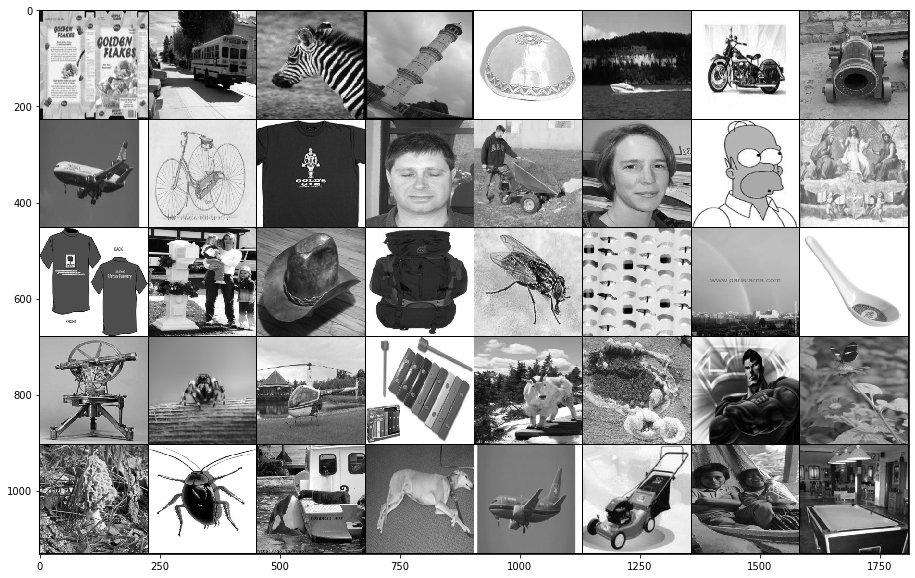

In [5]:
# sample images를 확인
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x_train = []
for batch, (X,y) in enumerate(train_dataloader):
    if batch<1:
        x_train.append(X)
    else:
        break


# tensor를 image로 변경하는 함수를 정의
def show(img):
    # tensor를 numpy array로 변경
    npimg = img.numpy()
    # C*H*W를 H*W*C로 변경
    npimg_tr = npimg.transpose((1,2,0))
    plt.figure(figsize=(20,10))
    plt.imshow(npimg_tr, interpolation='nearest',cmap='gray')

# images grid를 생성하고 출력
# 총 40개 이미지, 행당 8개 이미지를 출력
x_grid = utils.make_grid(x_train[0][:40], nrow=8, padding=2)

show(x_grid)

## Define Model

In [6]:
import torch
import torch.nn as nn

class VGGNet(nn.Module):

    def __init__(self, num_classes=257):
        super(VGGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
             nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [7]:
model = VGGNet()
summary(model,(1,224,224),batch_size=256)
model.to(mps_device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [256, 64, 224, 224]             640
              ReLU-2        [256, 64, 224, 224]               0
            Conv2d-3        [256, 64, 224, 224]          36,928
              ReLU-4        [256, 64, 224, 224]               0
         MaxPool2d-5        [256, 64, 112, 112]               0
            Conv2d-6       [256, 128, 112, 112]          73,856
              ReLU-7       [256, 128, 112, 112]               0
            Conv2d-8       [256, 128, 112, 112]         147,584
              ReLU-9       [256, 128, 112, 112]               0
        MaxPool2d-10         [256, 128, 56, 56]               0
           Conv2d-11         [256, 256, 56, 56]         295,168
             ReLU-12         [256, 256, 56, 56]               0
           Conv2d-13         [256, 256, 56, 56]         590,080
             ReLU-14         [256, 256,

VGGNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), 

In [8]:
learning_rate = 0.01
batch_size = 256
epochs = 40

In [9]:
loss_fn = nn.CrossEntropyLoss()

In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9, weight_decay=0.0005)

In [11]:
train_acc, train_loss = [],[]
test_acc, test_loss = [],[]

In [12]:
for t in range(epochs):
    tr_acc, tr_loss = train_loop(True,'GPU',train_dataloader,model,loss_fn,optimizer)
    te_acc, te_loss = test_loop(False, 'GPU',test_dataloader, model, loss_fn)
    train_acc.append(tr_acc)
    train_loss.append(tr_loss[-1])
    test_acc.append(te_acc)
    test_loss.append(te_loss)
    print(f'epoch {t+1}')
    print('train loss: %.6f train acc: %.2f\ntest  loss: %.6f, test acc: %.2f' %(tr_loss[-1],100*tr_acc, te_loss, 100*te_acc))
    print('-'*10)

loss: 5.549997 [    0/30607]
loss: 5.547628 [ 2560/30607]
loss: 5.546360 [ 5120/30607]
loss: 5.542966 [ 7680/30607]
loss: 5.536972 [10240/30607]
loss: 5.538181 [12800/30607]
loss: 5.536465 [15360/30607]
loss: 5.528540 [17920/30607]
loss: 5.528680 [20480/30607]
loss: 5.491628 [23040/30607]


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG13XFamilyCommandBuffer: 0xb10615f90>
    label = <none> 
    device = <AGXG13XDevice: 0x10f978c00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x10ba53000>
        label = <none> 
        device = <AGXG13XDevice: 0x10f978c00>
            name = Apple M1 Pro 
    retainedReferences = 1


loss: 5.528975 [25600/30607]


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG13XFamilyCommandBuffer: 0xb10717490>
    label = <none> 
    device = <AGXG13XDevice: 0x10f978c00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x10ba53000>
        label = <none> 
        device = <AGXG13XDevice: 0x10f978c00>
            name = Apple M1 Pro 
    retainedReferences = 1


loss: 5.522429 [28160/30607]
epoch 1
train loss: 5.522429 train acc: 2.36
test  loss: 5.521570, test acc: 2.63
----------
loss: 5.523253 [    0/30607]
loss: 5.520988 [ 2560/30607]
loss: 5.514112 [ 5120/30607]
loss: 5.511403 [ 7680/30607]
loss: 5.505966 [10240/30607]
loss: 5.507111 [12800/30607]
loss: 5.500566 [15360/30607]
loss: 5.446910 [17920/30607]
loss: 5.462355 [20480/30607]
loss: 5.384830 [23040/30607]
loss: 5.496500 [25600/30607]
loss: 5.501122 [28160/30607]
epoch 2
train loss: 5.501122 train acc: 1.57
test  loss: 5.484663, test acc: 2.70
----------
loss: 5.473498 [    0/30607]
loss: 5.555150 [ 2560/30607]
loss: 5.494173 [ 5120/30607]
loss: 5.432137 [ 7680/30607]
loss: 5.482604 [10240/30607]
loss: 5.473814 [12800/30607]
loss: 5.424252 [15360/30607]
loss: 5.509972 [17920/30607]
loss: 5.364441 [20480/30607]
loss: 5.366609 [23040/30607]
loss: 5.451789 [25600/30607]
loss: 5.433768 [28160/30607]
epoch 3
train loss: 5.433768 train acc: 2.75
test  loss: 5.418980, test acc: 2.87
-------

KeyboardInterrupt: 

## Result of Caltech256 Dataset

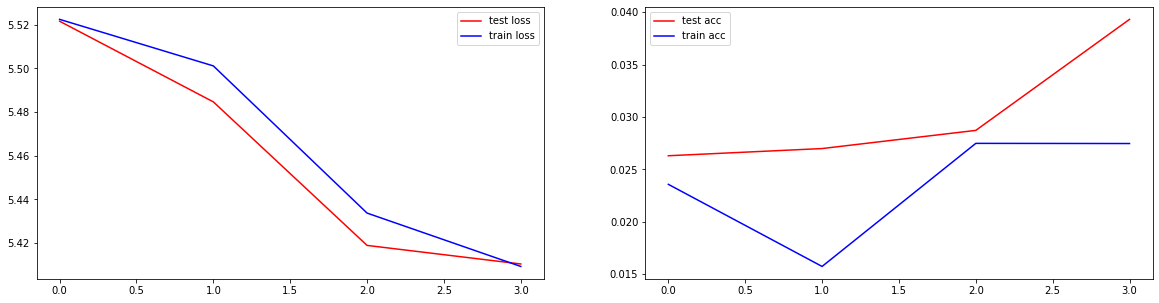

In [13]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
ax.plot(test_loss,'-r',label='test loss')
ax.plot(train_loss,'-b',label='train loss')
ax.legend()
ax = fig.add_subplot(1,2,2)
ax.plot(test_acc,'-r',label='test acc')
ax.plot(train_acc,'-b',label='train acc')
ax.legend()

### 10 epochs more training

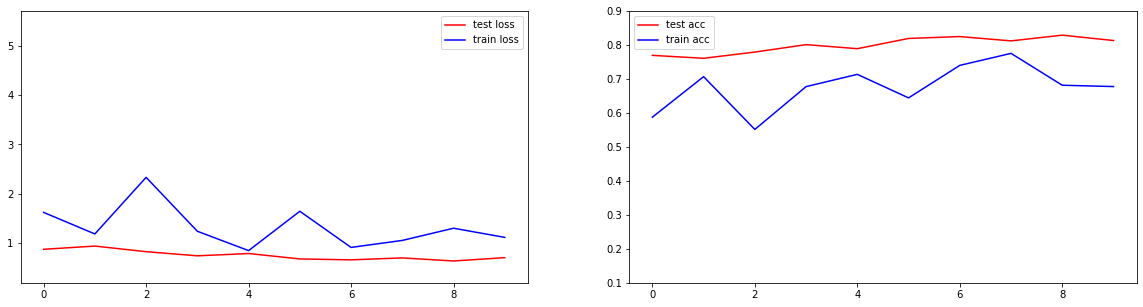

In [ ]:
from matplotlib.pyplot import yticks


fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
ax.plot(test_loss,'-r',label='test loss')
ax.plot(train_loss,'-b',label='train loss')
ax.set_ylim(0.2,5.7)
ax.legend()
ax = fig.add_subplot(1,2,2)
ax.plot(test_acc,'-r',label='test acc')
ax.plot(train_acc,'-b',label='train acc')
ax.set_ylim(0.1,0.9)
ax.legend()